# 03 Data Modelling

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import yaml

Reading files

In [2]:
try:
    with open('../params.yml','r') as file:
        config = yaml.safe_load(file)  
except Exception as e:
    print('Error reading the config file')

In [3]:
config

{'raw_data_1': '../01_data/PDB_31-07-2011.csv',
 'raw_data_2': '../01_data/PDB_31-12-2012.csv',
 'data': '../01_data/data.csv',
 'new_data': '../01_data/new_data.csv',
 'xy': '../01_data/xy.csv',
 'xy_06': '../01_data/xy_06.csv',
 'xy_enc': '../01_data/xy_enc.csv'}

In [4]:
xy = pd.read_csv(config['xy_enc'])[:50000]
xy.head()

,AA-2i_C,AA-2i_D,AA-2i_E,AA-2i_F,AA-2i_G,AA-2i_H,AA-2i_I,AA-2i_K,AA-2i_L,AA-2i_M,...,AA+2_Q,AA+2_R,AA+2_S,AA+2_T,AA+2_V,AA+2_W,AA+2_X,AA+2_Y,y3,y8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H,H
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H,H
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,H,H
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H,H
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H,H


In [7]:
x = xy.iloc[:,0:100].to_numpy()
y3 = xy['y3']#.to_numpy()
y8 = xy['y8']#.to_numpy()

In [8]:
xy['y3_n'] = [1 if x=='H' else (2 if x=='C' else 3) for x in xy['y3'] ]
y3_n = xy['y3_n']
y3_n

0        1
1        1
2        1
3        1
4        1
        ..
49995    3
49996    3
49997    3
49998    2
49999    2
Name: y3_n, Length: 50000, dtype: int64

### Splitting train-test

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y3, test_size=0.3)

In [10]:
len(y_train)

35000

### Downsampling

In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

x_train_under, y_train_under = rus.fit_resample(x_train,y_train)

In [12]:
y_train_under.value_counts()

C    8306
E    8306
H    8306
Name: y3, dtype: int64

### Testing several models on 3-types

In [17]:
names = ["Nearest Neighbors", "Linear SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Gradient Boosting", "Naive Bayes", "LDA", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

In [1]:
%%writefile -a functions.py

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import cohen_kappa_score

def search_model(names, classifiers, x_train, y_train, x_test, y_test)

    # iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train.values.ravel())
    score = clf.score(x_test, y_test)
    kappa = cohen_kappa_score(y_test, clf.predict(x_test))
    
    return name, score, kappa

Appending to functions.py


In [ ]:
%run functions.py

Nearest Neighbors 0.4598 0.15514771565691277
Linear SVM 0.5650666666666667 0.3412029178288377
Decision Tree 0.45153333333333334 0.1733173571662312
Random Forest 0.5406 0.30148919206488756
AdaBoost 0.5520666666666667 0.3218234078217309
Gradient Boosting 0.5607333333333333 0.33335743098785753
Naive Bayes 0.5072 0.2195663719877483
LDA 0.5622 0.3384281807122864


C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA 0.4059333333333333 0.006693000876419664


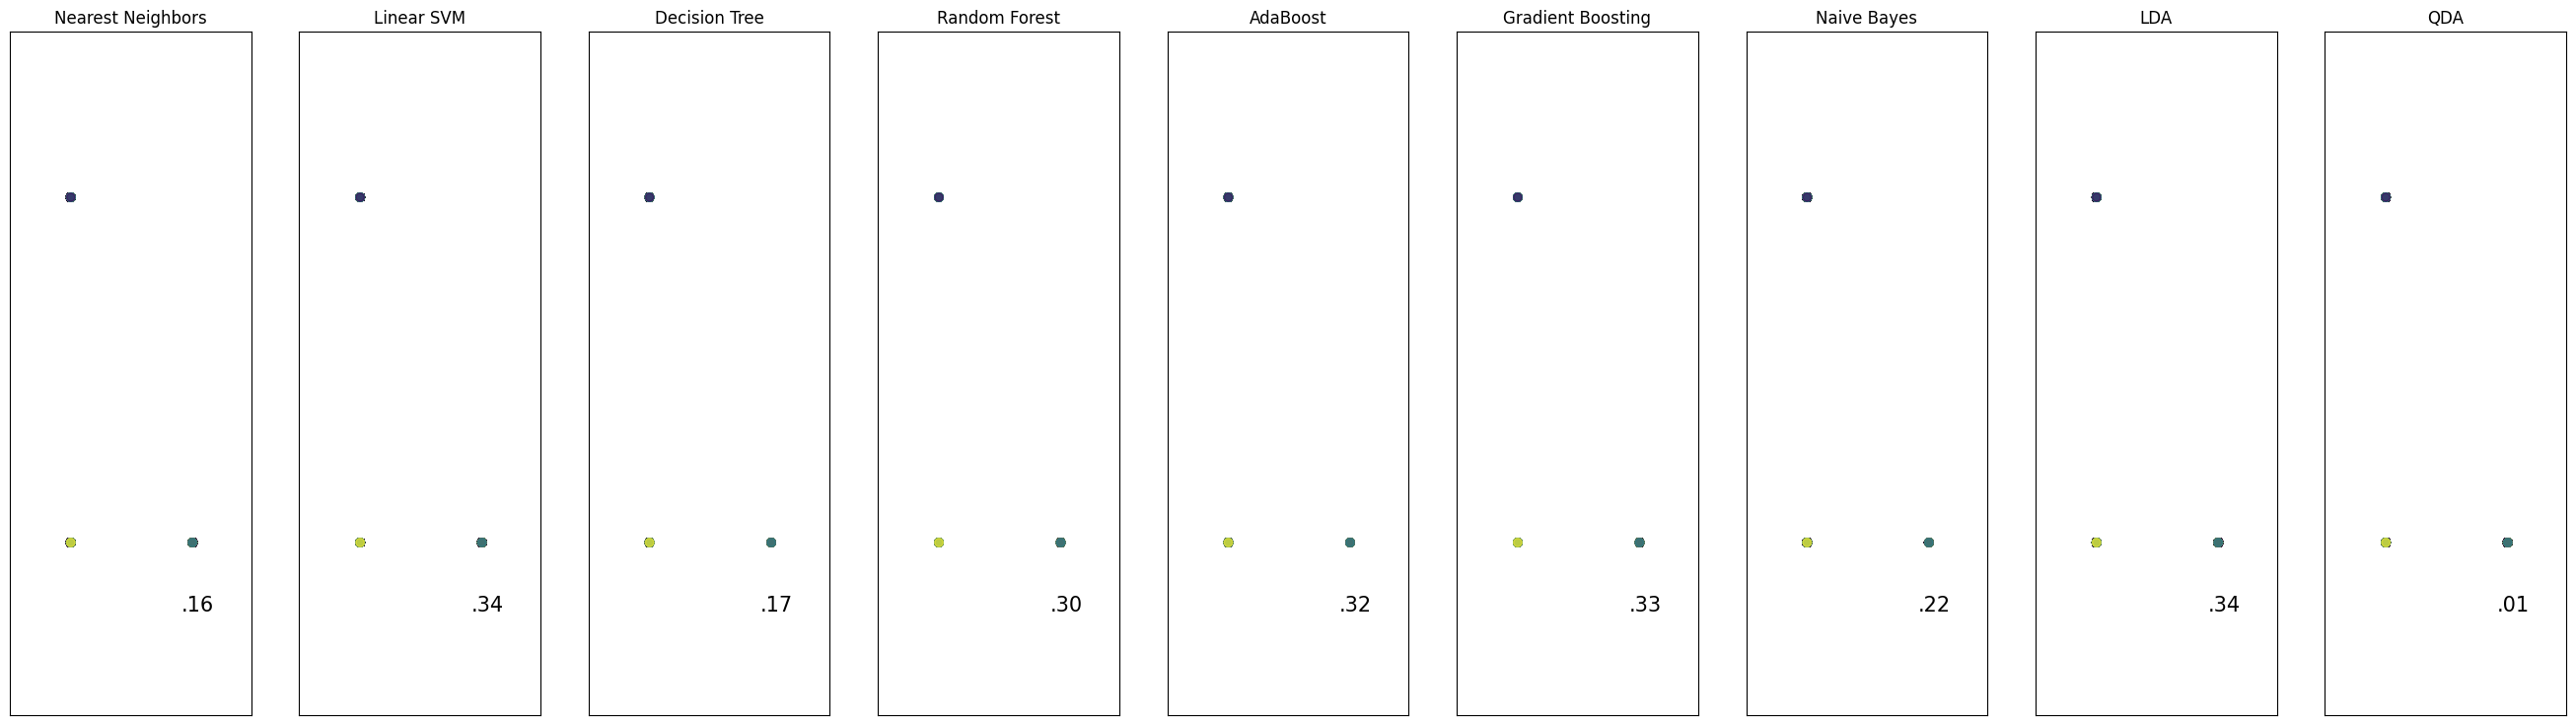

In [18]:
search_model(names, classifiers, x_train_under, y_train_under, x_test, y_test)

### Obtaining the best parameters for the best model

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Create the  grid 

grid = {'C' : [1,2],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [3,4],
        'gamma' : ['scale', 'auto'],
    'max_iter' : [1,-1]}

# Instantiate the grid search model object
model = SVC(kernel="linear", C=0.025)

grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5, scoring=make_scorer(cohen_kappa_score)) 

grid_search.fit(x_train_under, y_train_under.values.ravel()) # Fit the grid search to the data

grid_search.best_params_

# in grid search you are more likely to get really good results in your training set, even with CV
print("The best R2 for the best hyperparameters is {:.2f}".format(grid_search.best_score_))


C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: Co

C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: Co

C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: Co

C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: Co

C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\joana\anaconda3\envs\proj_w9\lib\site-packages\sklearn\svm\_base.py:299: Co

The best R2 for the best hyperparameters is 0.34


In [23]:
grid_search.best_params_

{'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1}

### Obtaining the score

In [ ]:
grid = {'C' : [1,2],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [3,4],
        'gamma' : ['scale', 'auto'],
    'max_iter' : [1,-1]}

# Instantiate the grid search model object
model = SVC(kernel="linear", C=0.025)

In [ ]:
from sklearn.metrics import classification_report

clf =  SVC( C=1, degree=3, gamma='scale', kernel='rbf', max_iter=-1)

clf.fit(x_train_under, y_train_under)

print("The R2 in the TRAIN set is {:.2f}".format(clf.score(x_train_under, y_train_under)))
print("The R2 in the TEST  set is {:.2f}".format(clf.score(x_test, y_test)))
print("The Cohen Kappa is",round(cohen_kappa_score(y_test, clf.predict(x_test)),2))
print(classification_report(y_test, clf.predict(x_test), zero_division = 0))

### Saving model

In [27]:
import pickle

In [ ]:
with open('../03_models/model.pickle', "wb") as file:
    pickle.dump(model,file)